In [1]:
#Importing libraries
import inv_mcmc
import numpy as np
from data import Data
from yang import Yang
from mogi import Mogi
from mctigue import Mctigue
from penny import Penny
from okada import Okada
import corner
import matplotlib.pyplot as plt
import pymc
import matplotlib
import util

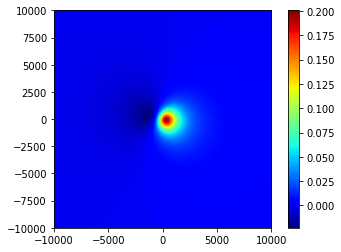

In [2]:
#Creating synthetic InSAR data

x=np.linspace(-10,10,100)*1000
y=np.linspace(-10,10,100)*1000
X,Y=np.meshgrid(x,y)

az=-3.42
lk=0.9

dat = Data('insar')
dat.add_locs(X.ravel(),Y.ravel())
dat.add_angles(az,lk)
mct = Mctigue(dat)
mct.set_bounds(low_bounds = [-10000, -10000, 0, 0, 1e6], high_bounds = [10000, 10000, 20000, 3000, 1e7])
los= mct.get_model_los([0,0,1000,500,1e6])

los=los.reshape(X.shape)

plt.figure()
plt.imshow(los,cmap='jet',extent=[np.min(x),np.max(x),np.min(y),np.max(y)])
plt.colorbar()

In [3]:
#Running quadtree to reduce number of samples in the interferogram
wl=0.055465764662349676
extent=[np.min(x),np.max(x),np.min(y),np.max(y)]
util.get_quadtree(los,az,lk,wl,extent,th=0.0003,unit='m')

logger - INFO - varrespy - v 1.0
logger - INFO - ----------------
read_igram - INFO - Original number of data points: 10000
resample - INFO - Resampling data
resample - INFO - Preparing geometry products
write - INFO - Output   File - newtest.txt




100 1.0 101.0 <reader.reader object at 0x7fde718e3040>
Samples :      202

Figure(640x480)


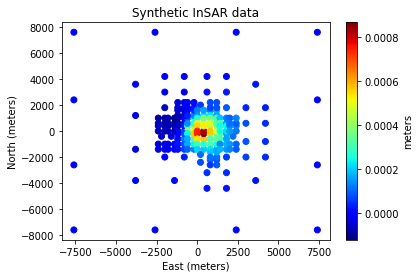

In [4]:
#Loading the data after the quadtree has been applied

archivo=open('./varres/newtest.txt','r')
lineas=archivo.readlines()
archivo.close()

xs,ys,los=[],[],[]
for linea in lineas[2::]:
    
    xs.append(float(linea.split()[3]))
    ys.append(float(linea.split()[4]))
    los.append(float(linea.split()[5])/100)
xs=np.array(xs)
ys=np.array(ys)
los=np.array(los)
los+=0.3*np.abs(los)*np.random.uniform(-1,1,len(los))

plt.figure()
plt.title('Synthetic InSAR data')
plt.scatter(xs,ys,c=los,cmap='jet')
plt.xlabel('East (meters)')
plt.ylabel('North (meters)')
plt.colorbar(label='meters')

In [5]:
#Creating synthetic GPS deformation

n=20
ran=np.random.uniform(-10*1e3, 10*1e3, size=(n,2))
xgps=ran[:,0]
ygps=ran[:,1]

dat = Data('gps')
dat.add_locs(xgps,ygps)
mct = Mctigue(dat)

ux,uy,uz=mct.forward_gps([0,0,1000,500,5e6])

Text(0.5, 0, 'X(km)')

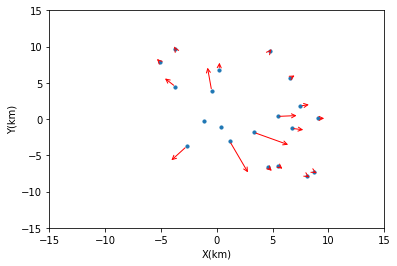

In [6]:
#Plotting GPS deformation
plt.figure()
plt.scatter(xgps/1e3,ygps/1e3,s=10)
scale=50
for i in range(len(xgps)):
    plt.annotate("", xy=(xgps[i]/1e3+ux[i]*scale, ygps[i]/1e3+uy[i]*scale), xytext=(xgps[i]/1e3, ygps[i]/1e3),arrowprops=dict(arrowstyle="->",color="red"))
plt.ylim(-15,15)
plt.xlim(-15,15)
plt.ylabel('Y(km)')
plt.xlabel('X(km)')

In [7]:
#Creating dataset for the inversion
dat = Data('joint')

#Adding the InSAR data to the joint dataset
dat.add_locs(xs,ys,unit='m',dataset='insar')
dat.add_angles(az,lk)
dat.add_los(los)

#Adding the GPS data to the joint dataset
dat.add_locs(xgps,ygps,unit='m',dataset='gps')
dat.add_disp(ux,uy,uz,dataset='gps')

In [8]:
#Creating the McTigue model that would be use in the inversion

mct = Mctigue(dat)
#Initial parameters [xcen,ycen,depth,volume change]
mct.set_x0(np.array([1000, 1000, 2000, 500, 2e6]))
#Bounds for parameters [xcen,ycen,depth,volume change]
mct.set_bounds(low_bounds = [-10000, -10000, 0, 0, 1e6], high_bounds = [10000, 10000, 20000, 3000, 1e7])

#Getting the data to run the inversion
data=dat.get_obs()

#ASSIGNING WEIGHTS TO INSAR AND GPS
weights=mct.get_weights([len(xs)/(2*len(xgps)),1.0])

#Running the MCMC inversion
data=dat.get_obs()
trace,MDL=inv_mcmc.inversion(mct,data,wts=weights)

Not reduced
Not reduced
 [-----------------100%-----------------] 1100000 of 1100000 complete in 1884.3 sec

1090
1090
1090
1090
1090


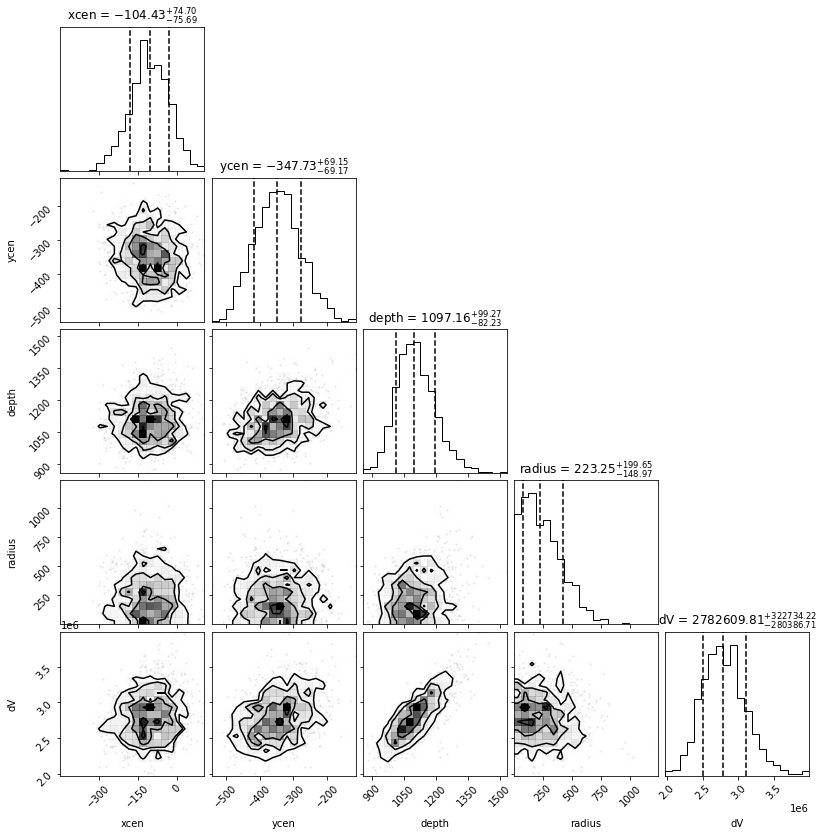

In [9]:
#Plotting the results

data=[]
labels=[]
parnames=mct.get_parnames()
orders=mct.get_orders()
for i,tr in enumerate(trace):
    print(len(tr[:]))
    data.append(tr[:]*orders[i])
    labels.append(parnames[i])
data=np.vstack(data)
figure = corner.corner(data.T, labels=labels,
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})
plt.savefig('histograms')